In [1]:
using LinearAlgebra
using SparseArrays
using StaticArrays
using JacobiDavidson
include("fala/fem/elements.jl")
include("fala/fem/basis.jl")
include("fala/fem/quadratures.jl")
include("fala/fem/transformations.jl")
include("fala/fem/integrals.jl")
include("fala/fem/assemble.jl")
include("fala/fem/meshes.jl")

ed2dof (generic function with 1 method)

In [2]:
include("2GHz-Radial-Cavity-Tri.jl")
nodes2coord = p
elems2nodes = t
element = N1curl()
nelems = size(t, 1)

2088

In [3]:
elems2edges = el2ed(elems2nodes, element)
edges2dofs = ed2dof(elems2edges)
numedges = maximum(abs, elems2edges)

# mark boundaries
numdofs = 0
local2edges = ledges(element)
for i=1:numedges
    if count(==(i), abs.(elems2edges)) > 1
        numdofs += 1
        edges2dofs[i] = numdofs
    else
        k, e = findfirst(==(i), abs.(elems2edges)).I
        a = elems2nodes[k, local2edges[e,1]]
        b = elems2nodes[k, local2edges[e,2]]
        r = nodes2coord[a, 2] + nodes2coord[b, 2]
        if r ≈ 0.0
            numdofs += 1
            edges2dofs[i] = numdofs
        else
            edges2dofs[i] = 0
        end
    end
end
numdofs = maximum(edges2dofs)

3111

In [4]:
S, T = assemble(element, nelems, numdofs, nodes2coord, elems2nodes, elems2edges, edges2dofs);
@show issymmetric(T);
T .-= triu(T) - triu(T') # symmetrize the mass matrix
@show issymmetric(T);

issymmetric(T) = true
issymmetric(T) = true


In [5]:
using LinearAlgebra
using Arpack
const c0 = 299_792_458.   # speed of light [m/s]
const ε0 = 8.85418781e-12 # vacuum permittivity [F/m]
const μ0 = 1.256637062e-6 # vacuum permeability [H/m]
const μr = 1.0
const ε  = ε0

@time k², e = eigen(Array(S), Array(T))
nothing

  6.121504 seconds (1.30 M allocations: 604.338 MiB, 0.67% gc time, 16.22% compilation time)


In [30]:
#shift and intevert lanchos ARPACK
@time λ, ϕ = Arpack.eigs(Array(S), Array(T), nev=6, sigma=2.0, which=:LR);

  1.157408 seconds (993 allocations: 449.417 MiB, 2.50% gc time)


In [31]:
 λ

6-element Vector{ComplexF64}:
 1760.8096900561877 + 0.0im
  5323.330208649167 + 0.0im
  8337.853114932888 + 0.0im
 13956.171798034346 + 0.0im
 14233.205805918078 + 0.0im
  19942.79865427302 + 0.0im

In [ ]:
using JacobiDavidson

target = Near(1.5 - 0.7im)

n=3111 
pschur, residuals = jdqz(
Array(S), Array(T),
solver = GMRES(n, iterations = 7),
target = target,
pairs = 5,
subspace_dimensions = 30:50,
max_iter = 20,
verbosity = 1
)

found = pschur.alphas ./ pschur.betas

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\Orange\.julia\packages\ProgressMeter\kVZZH\src\ProgressMeter.jl:594
Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:30
  Residual:  270.31240137220766
  λ:         NaN + 0.0im
  Pairs:     0/5

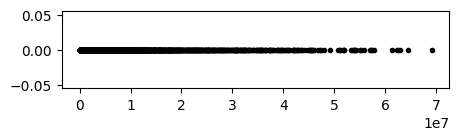

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000015ECB608910>

In [8]:
using PyPlot
figure(figsize=(5, 1))
plot([real(k_sq) for k_sq in k²], [imag(k_sq) for k_sq in k²], "k.")

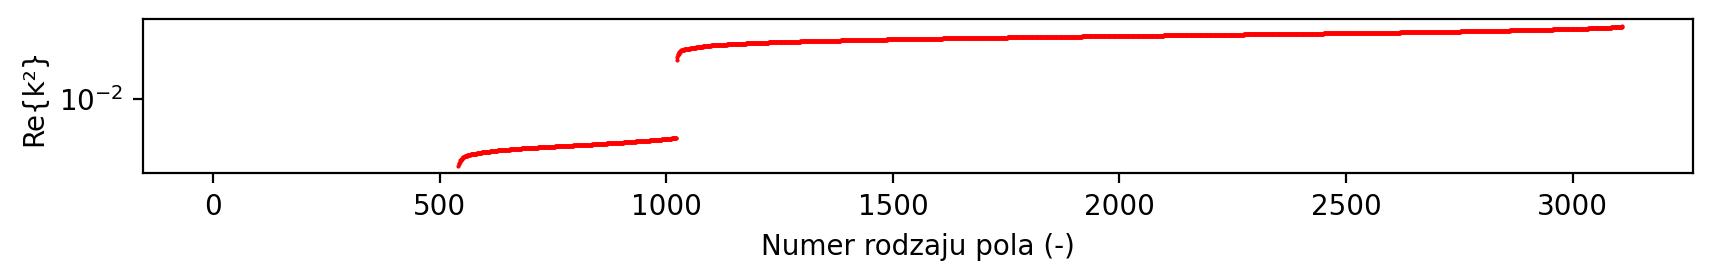

(PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0000015ECB6CF5B0>], PyObject Text(47.999999999999986, 0.5, 'Re{k²}'), PyObject Text(0.5, 48.0, 'Numer rodzaju pola (-)'))

In [9]:
figure(figsize=(10, 1), dpi=200)
semilogy(real.(k²), "r.", markersize=1), ylabel("Re{k²}"), xlabel("Numer rodzaju pola (-)")

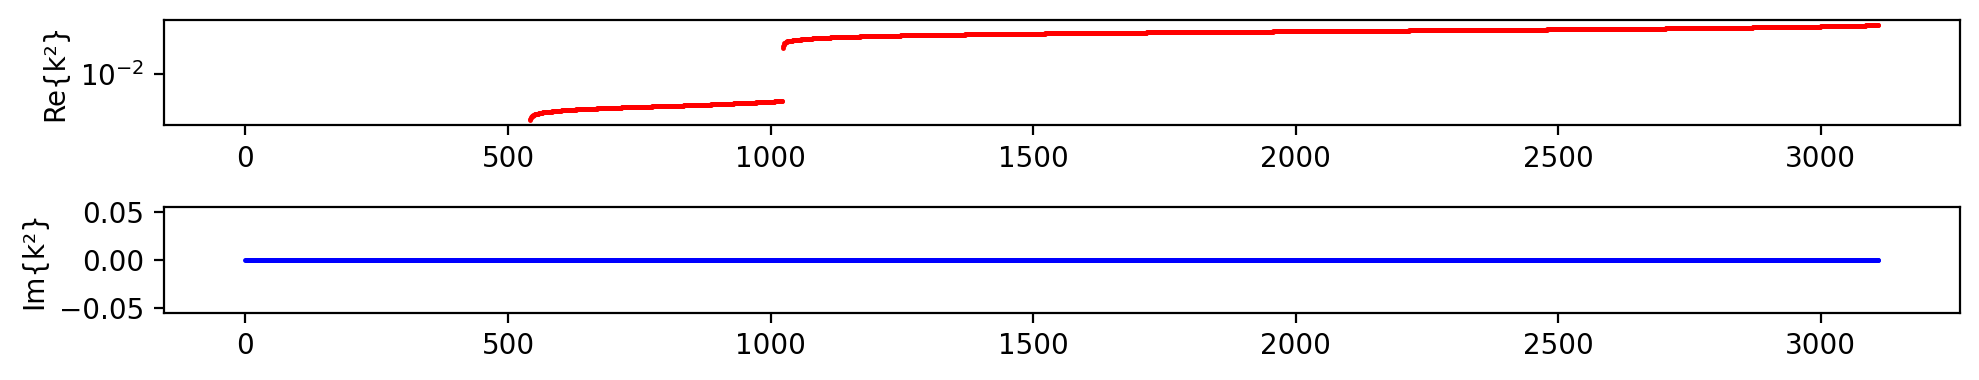

In [10]:
figure(figsize=(10, 2), dpi=200)
subplot(2,1,1); semilogy(real.(k²), "r.", markersize=1.5), ylabel("Re{k²}")
subplot(2,1,2); plot(imag.(k²), "b.", markersize=1.5), ylabel("Im{k²}")
tight_layout()

In [22]:
include("fala/fem/evaluate.jl")
n = findfirst(>(1e-2), k²) + 0
f = sqrt(k²[n]) / 2π * c0
println("f = ", 1e-6f, " MHz")

f = 2002.1519956084712 MHz


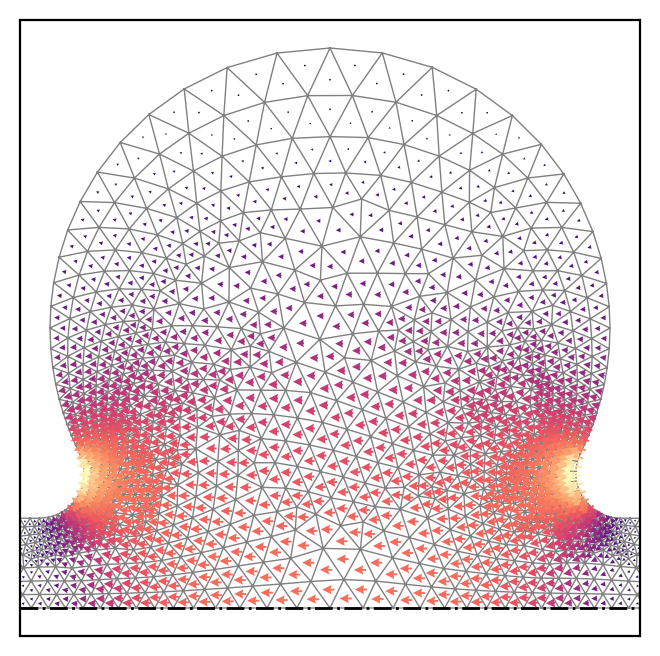

In [12]:
using PyPlot
figure(figsize=(4,4), dpi=200)

x, y, u, v = vector_field(element, nodes2coord, elems2nodes, elems2edges, edges2dofs, real.(e[:,n]))
mag = @. sqrt(u^2 + v^2)
normalize!(mag, Inf)
axhline(0.0, color="black", linewidth=1, linestyle="dashdot")
triplot(nodes2coord[:,1], nodes2coord[:,2], triangles=(elems2nodes .- 1), linewidth=0.5, color="grey")
quiver(x, y, u, v, mag, width=0.003, headwidth=5, color="black", pivot="mid", cmap="magma")#, clim((0, 1))
axis("equal")
xticks([])
yticks([])
xlim((-5e-3, +5e-3))
nothing

In [13]:
[sqrt(k²[m]) / 2π * c0 * 1e-9 for m in n:n+5]

6-element Vector{Float64}:
 2.0021519956084717
 3.4812285600109814
 4.356803316497929
 5.636687889043139
 5.692357914708076
 6.7380446860669085

In [24]:
[k²[m] for m in n:n+5]

6-element Vector{Float64}:
  1760.8096900539645
  5323.330208648463
  8337.853114927791
 13956.171798035235
 14233.205805917629
 19942.79865427683

In [35]:
[sqrt(λ[m]) / 2π * c0 * 1e-9 for m in 1:5]

5-element Vector{ComplexF64}:
 2.0021519956097356 + 0.0im
 3.4812285600112123 + 0.0im
  4.356803316499261 + 0.0im
  5.636687889042959 + 0.0im
 5.6923579147081655 + 0.0im